# NLP on PRR: Data Processing Pipeline & Theoretical Models

In [1]:
import spacy
import pandas as pd
import xlrd
#from sklearn.manifold import TSNE
from spacy.tokenizer import Tokenizer
from gensim.models import Word2Vec, ldamodel
from gensim.models.phrases import Phrases, Phraser
from gensim.corpora import Dictionary
from collections import Counter
import itertools
from spacy.lang.en.stop_words import STOP_WORDS
import re
import numpy as np
import matplotlib.pyplot as plt
import pprint
import time
import os
from sklearn.manifold import TSNE

# this isn't strictly an import, but it's used globally
pp = pprint.PrettyPrinter()

# change the model for different word vectors
nlp = spacy.load('en_core_web_lg')

# and finally, suppress an annoying warning that pandas throws
# when using straightforward indexing methods
pd.options.mode.chained_assignment = None

## Project 0: Cleaning the Data and Cursory Analysis
Let's load things up! In this section, we use some excel files received from different municipalities, and do a number of different transformations to them.

In [2]:
# this section loads data from a number of files
#
# these have essentially the same formatting
seadata = pd.read_excel('reformatted.xlsx')
olydata = pd.read_excel('StudentPRRLog_06212018_2.xlsx')

# this file has a bunch of unnecessary rows at the top
# so we have to specify the header row for this file
pordata = pd.read_excel('Port Orchard PRR Data.xls', header=9)

In [3]:
pordata.head(1)

,Unnamed: 0,Assigned Dept,Close Date,Unnamed: 3,Create Date,Unnamed: 5,Unnamed: 6,Reference No,Request Status,Request Type,Unnamed: 10,Customer Full Name,Unnamed: 12,Public Record Desired
0,NaN,City Clerk's Office,2016-06-16 16:22:00,NaN,2016-06-10 22:38:00,NaN,NaN,P000151-061016,No Responsive Records,Public Records Request,NaN,Ted Macomber,NaN,I am requesting a copy of any allegations of p...


In [4]:
pordata.columns

Index(['Unnamed: 0', 'Assigned Dept', 'Close Date', 'Unnamed: 3',
       'Create Date', 'Unnamed: 5', 'Unnamed: 6', 'Reference No',
       'Request Status', 'Request Type', 'Unnamed: 10', 'Customer Full Name',
       'Unnamed: 12', 'Public Record Desired'],
      dtype='object')

In [5]:
pordata.describe()

,Unnamed: 0,Unnamed: 3,Unnamed: 5,Unnamed: 6,Unnamed: 10
count,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN


In [6]:
olydata.head(1)

,Reference No,Create Date,SRB07_Estimated_Completion_Date,SRB08_Actual_Completion_Date,Assigned Dept,Request Status,Public Record Desired,Request Type,Type of Requester,Type of Incident,Case Number
0,W012108-061818,2018-06-18 12:37:00,2018-07-18,2018-06-20,Olympia Police Department,Full Release,Copy of police report,Police Public Records Request,Individuals,"Dv assult 4, reckless endangerment",NaN


In [7]:
olydata.columns

Index(['Reference No', 'Create Date', 'SRB07_Estimated_Completion_Date',
       'SRB08_Actual_Completion_Date', 'Assigned Dept', 'Request Status',
       'Public Record Desired', 'Request Type', 'Type of Requester',
       'Type of Incident', 'Case Number'],
      dtype='object')

In [8]:
olydata.describe()

,Reference No,Create Date,SRB07_Estimated_Completion_Date,SRB08_Actual_Completion_Date,Assigned Dept,Request Status,Public Record Desired,Request Type,Type of Requester,Type of Incident,Case Number
count,7655,7655,397,2943,7640,7655,7655,7655,691,2324,3206
unique,7655,7236,176,244,11,12,6769,2,10,1169,2884
top,W005076-022916,2017-01-30 08:00:00,2017-08-24 00:00:00,2017-07-24 00:00:00,Olympia Police Department,Full Release,Police - Incident Reports/Calls For Service Re...,Police Public Records Request,Individuals,Auto Theft,Unknown
freq,1,6,45,31,5118,5432,313,4960,406,78,22
first,NaN,2010-12-10 10:21:00,2014-10-01 00:00:00,2016-08-22 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2018-06-18 12:37:00,2018-12-19 00:00:00,2018-06-21 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
seadata.head(1)

,issue_id,",",assigned_dept_id,",.1",department_name,",.2",assigned_staff_id,",.3",assigned_staff_name,",.4",...,Unnamed: 72,Unnamed: 73,Unnamed: 74,Unnamed: 75,Unnamed: 76,Unnamed: 77,Unnamed: 78,Unnamed: 79,Unnamed: 80,Unnamed: 81
NaN,1017,",",16,",",SPD,",",11677,",",Sauncy Hurst,",",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
seadata.columns

Index(['issue_id', ',', 'assigned_dept_id', ',.1', 'department_name', ',.2',
       'assigned_staff_id', ',.3', 'assigned_staff_name', ',.4', 'create_date',
       ',.5', 'customer_id', ',.6', 'customer_email', ',.7',
       'customer_email_domain', ',.8', 'customer_full_name', ',.9',
       'customer_first_name', ',.10', 'customer_last_name', ',.11',
       'is_closed', ',.12', 'reference_no', ',.13', 'request_summary', ',.14',
       'request_type_description', ',.15', 'service_request_status_id', ',.16',
       'request_status_name', ',.17', 'service_request_type_id', ',.18',
       'request_type_name', ',.19', 'status_desc', ',.20', 'update_date',
       ',.21', 'city_public_record_description', ',.22',
       'spd_receipt_of_records_preference', ',.23',
       'spd_overall_rec_req_description', ',.24', 'spd_rec_req_other_details',
       ',.25', 'all_requester_type_internal', ',.26',
       'city_request_synopsis_internal', 'Unnamed: 55', 'Unnamed: 56',
       'Unnamed: 57', 'Unna

In [11]:
seadata.describe()

,issue_id,assigned_dept_id,assigned_staff_id,customer_id,Unnamed: 78
count,23415.000000,23415.000000,23415.000000,23415.000000,0.0
mean,12864.784796,19.268119,11828.796797,5165.406961,NaN
std,6800.175114,9.830225,2900.139636,3550.089361,NaN
min,1017.000000,1.000000,0.000000,92.000000,NaN
25%,7013.500000,16.000000,11675.000000,1970.000000,NaN
50%,12876.000000,16.000000,11681.000000,4699.000000,NaN
75%,18753.500000,19.000000,13802.000000,7985.500000,NaN
max,24616.000000,62.000000,14107.000000,12375.000000,NaN


## Notes on cleaning

We can see from the beginning here that there are many differences between the datasets. Some have more information with others, some have extraneous columns, some are combined from other resources, and so on. Since the only factor in common (other than the body of the request itself) is the department corresponding with the request, and the date generated, we'll be using those for the analysis in this project.

On that note, let's get to cleaning!

In [19]:
# this is a helper function to clean text in place
def clean(text):
    # ARGUMENTS: text; a string of whatever length
    # OUTPUTS: cleaned text; a string of whatever length
    #
    # this is a regular expression for processing dates
    #
    datesplit = re.compile('\d+|\D+')    
    # more complex formatting (i.e.
    # unicode characters) has to be handled properly
    text = text.replace("\t", " ")
    text = text.replace("\p", " ")
    text = text.replace('\uf07f', " ")
    text = text.replace('\uf0b7', " ")
    text = text.replace('\uf071', " ")
    return text

In [20]:
# reindex the data above, using only the columns we care about, for olympia
oly_trunc = olydata[['Assigned Dept', 'Create Date', 'Public Record Desired']]
oly_trunc.columns = ['department_name', 'create_date', 'request_summary']

# convert everything in the request_summary column to a spring, so no errors
# are thrown when doing natural language processing on data later
oly_trunc['request_summary'] = oly_trunc['request_summary'].astype(str)
oly_trunc['request_summary'] = oly_trunc['request_summary'].apply(lambda x: clean(x))

# then drop all of the null values
oly_trunc = oly_trunc.dropna().reset_index().set_index('create_date')

# and add a column that corresponds with the origin of this data (for later)
oly_trunc['loc'] = 'OLY'
del oly_trunc['index']

# and similar, but for port orchard
droplist = [column for column in pordata.columns if 'Unnamed' in column]
pordata.drop(droplist, axis=1, inplace=True)
por_trunc = pordata[['Assigned Dept', 'Create Date', 'Public Record Desired']]
por_trunc.columns = ['department_name', 'create_date', 'request_summary']
por_trunc['request_summary'] = por_trunc['request_summary'].astype(str)
por_trunc['request_summary'] = por_trunc['request_summary'].apply(lambda x: clean(x))
por_trunc = por_trunc.dropna().reset_index().set_index('create_date')
por_trunc['loc'] = 'POR'
del por_trunc['index']

# same, but for seattle
sea_trunc = seadata[['department_name', 'create_date', 'request_summary']]
sea_trunc['request_summary'] = sea_trunc['request_summary'].astype(str)
sea_trunc['request_summary'] = sea_trunc['request_summary'].apply(lambda x: clean(x))
sea_trunc = sea_trunc.dropna().reset_index().set_index('create_date')
sea_trunc['loc'] = 'SEA'
del sea_trunc['index']

# number of entries in the truncated data blocks
print("olympia data entries:", len(oly_trunc),
      "\nseattle data entries:", len(sea_trunc),
      "\nport orchard data entries:", len(por_trunc))
#sum(truncated.request_type_description != truncated.spd_overall_rec_req_description)

# later on, consider using NA values as test set for topic modeling. might be overkill?

olympia data entries: 7640 
seattle data entries: 23414 
port orchard data entries: 246


In [21]:
# here's a list of all of the possible departments we can choose from
# as well as the overall percentage that they make up
#

def dept_count_pct(df):
    depts = df['department_name'].value_counts()
    deptsdf = pd.DataFrame(depts)
    deptsdf['pct'] = (deptsdf['department_name'] / len(df)).round(5)
    return deptsdf

dept_count_pct(oly_trunc)

,department_name,pct
Olympia Police Department,5118,0.66990
Community Planning and Development,1435,0.18783
Multiple Departments,317,0.04149
Fire,253,0.03312
Administrative Services,183,0.02395
Public Works,169,0.02212
Human Resources,77,0.01008
Legal,43,0.00563
Executive,24,0.00314
Parks,18,0.00236


In [22]:
dept_count_pct(sea_trunc)

,department_name,pct
SPD,13803,0.58952
SFD,3976,0.16981
Site Administrator,939,0.04010
SCI,809,0.03455
FAS,740,0.03161
DOT,667,0.02849
LAW,297,0.01268
LEG,294,0.01256
SCL,279,0.01192
SPU,270,0.01153


In [23]:
dept_count_pct(por_trunc)

,department_name,pct
City Clerk's Office,183,0.74390
Community Development,45,0.18293
Public Works Department,14,0.05691
Site Administrator,3,0.01220
Finance Department,1,0.00407


Now that the data is clean and massaged into a form that we can easily work with, we should try to gather some descriptive information about records. Namely, how long are they, on average? We'll measure this in terms of characters, as well as tokens (words).

In [27]:
# this is a helper function that gives us the average length in characters
# for each request for each department, and then a higher-level descriptive table
# of the same
def avglen(df):
    # ARGUMENTS: df; a dataframe
    # OUTPUTS: a dict; containing column name, average len in chars, number of requests
    #
    
    # get a shortlist of all the names of departments
    names = set(df.department_name.values)
    
    # create a sub-indexed df for each department name
    # for requests
    requestlist = [df[df.department_name == i]['request_summary'] 
               for i in names]
    
    # and for tokens
    tokenlist = [df[df.department_name == i]['tokens'] 
               for i in names]
    
    # count the number of requests and tokens for each dataframe above
    l, t = [len(i) for i in requestlist], [len(i) for i in tokenlist]

    # and then get a sum for each department
    rq = [sum([len(str(j)) for j in i]) for i in requestlist]
    tk = [sum([len(j) for j in i]) for i in tokenlist]
    
    # then average lengths and tokens together
    avglen = [i / j for i,j in zip(rq, l)]
    avgtok = [i / j for i,j in zip(tk, l)]
    
    # create a dictionary that combines the dept name, the length
    # in characters, and the requests per department
    lendict = {n : (v, r, e) for n, v, r, e in zip(names, avglen, avgtok, l)}

    # and recombine that into a dataframe
    return pd.DataFrame.from_dict(lendict, orient='index',
                             columns=['average length (chars)',
                                      'average number of tokens',
                                      'requests per dept'])

In order to get the tokens (the individual component parts of a sentence/request), we have to process the data. Fortunately, there's a package that does that for us. Take it away, spacy!

In [28]:
# this uses the spacy natural language processing function
# on the requests, casting them to new columns

# watch out when you run it, because it takes about 15min to process
por_trunc['tokens'] = por_trunc['request_summary'].apply(lambda x: nlp(x))
oly_trunc['tokens'] = oly_trunc['request_summary'].apply(lambda x: nlp(x))
sea_trunc['tokens'] = sea_trunc['request_summary'].apply(lambda x: nlp(x))

In [29]:
olyagl = avglen(oly_trunc)
olyagl

,average length (chars),average number of tokens,requests per dept
Fire,101.988142,19.703557,253
Executive,316.291667,57.458333,24
Public Works,292.502959,54.514793,169
Olympia Police Department,152.511333,30.677218,5118
Municipal Court,53.000000,10.000000,3
Legal,170.395349,33.209302,43
Multiple Departments,436.861199,82.230284,317
Parks,241.333333,42.555556,18
Human Resources,297.311688,55.506494,77
Administrative Services,250.065574,48.770492,183


In [30]:
poragl = avglen(por_trunc)
poragl

,average length (chars),average number of tokens,requests per dept
Site Administrator,3.000000,1.000000,3
Public Works Department,284.785714,56.214286,14
City Clerk's Office,388.480874,74.672131,183
Finance Department,192.000000,36.000000,1
Community Development,267.333333,56.200000,45


In [31]:
seaagl = avglen(sea_trunc)
seaagl

,average length (chars),average number of tokens,requests per dept
SCI,501.159456,91.676143,809
SFD,94.916499,16.104879,3976
RET,435.828947,81.355263,76
OLS,392.400000,73.520000,25
MOS,571.803571,107.397321,224
ART,697.875000,135.000000,8
LAW,427.646465,79.686869,297
FAS,423.393243,79.539189,740
LEG,433.112245,79.945578,294
SPU,442.125926,81.648148,270


In [32]:
# concatenate descriptions of these dataframes into one
# bigger dataframe

desc = {'seattle': seaagl.describe()[1:],
                'olympia': olyagl.describe()[1:],
                'port orchard' : poragl.describe()[1:]}

descriptions = pd.concat(desc)
descriptions

average length (chars)  average number of tokens  \
olympia      mean              226.336325                 42.719883   
             std               109.130513                 20.021314   
             min                53.000000                 10.000000   
             25%               161.453341                 31.943260   
             50%               241.333333                 42.555556   
             75%               294.907323                 55.010643   
             max               436.861199                 82.230284   
port orchard mean              227.119984                 44.817283   
             std               143.564417                 28.055608   
             min                 3.000000                  1.000000   
             25%               192.000000                 36.000000   
             50%               267.333333                 56.200000   
             75%               284.785714                 56.214286   
             max               388.480874                 74.672131   
seattle      mean              439.426111                 81.686967   
             std               226.468723                 43.695560   
             min                16.053248                  2.486688   
             25%               350.169231                 65.227273   
             50%               435.828947                 81.355263   
             75%               504.879310                 93.545455   
             max              1374.833333                269.000000   

                   requests per dept  
olympia      mean         694.545455  
             std         1522.565490  
             min            3.000000  
             25%           33.500000  
             50%          169.000000  
             75%          285.000000  
             max         5118.000000  
port orchard mean          49.200000  
             std           76.838792  
             min            1.000000  
             25%            3.000000  
             50%           14.000000  
             75%           45.000000  
             max          183.000000  
seattle      mean         632.810811  
             std         2324.556336  
             min            1.000000  
             25%           11.000000  
             50%           58.000000  
             75%          270.000000  
             max        13803.000000

# Cleaning the data: Discussion

## Observations
We can see that--far and away--the police departments for each city have the most requests submitted to them. Further, it's apparent that--while the mean length of record request is about the same for each city--Seattle has a wide variance as to how long requests are, and it also has the longest request associated with it. Seattle has twice as many words per requests than the other two cities.

## Data pipeline
At the onset of this project, we obtained data extracts from a number of institutions and municipalities of different sizes, with the intention of collating them into one repository for analysis. Upon receipt, there were a handful of things that we realized, which dramatically reduced the kind of analysis that we could perform on the data.

1. **Government bodies have different reporting standards for metadata.** I believe this is related to the platform/infrastructure the institution is using to fulfill and manage requests. The fields of interest, as well as the types of data accessible within those fields, are often so distinct that they cannot be combined in a straightforward way. For example, some municipalities have tons of great metadata reporting, especially around the estimated amount of time and actual amount of time that it took to fulfill a request.

2. **Inputs are not standardized.** Both people and institutions submit public records requests, which means that there are differing degrees of detail, complexity, and formatting. Some people submit a few words or a case number in their request, while others copy-paste several spreadsheet columns. 

3. **There is personal identifying information everywhere.** The more I dug into records requests, the more I saw people signing their requests with their name, address, and contact information. It's hard to strip out this information with software, especially because requests ask for information on a particular person or named entity. This is problematic for open data projects, namely because 

4. **All data are equal, but some data are more equal than others.** This project charts out some methods that can be used across departments that have different numbers of records requests, but there's little we can do (and little inference we can provide) for a department that has but one solitary request.

The confluence of all of these factors effectively means that it's hard to look for trends. *Not great.*

It's really important to clean and harmonize the data as best we can. As such, we ended up throwing away most of the data that we had and working with a much smaller subset. After importing the data into a pandas dataframe, we kept:

- The department name (a string);
- Record creation date (a datetime object)
- Request summary (a string)

It's important to keep the orthography of the names the same, otherwise the information flow in the code here will break.

## Future: Metadata standards
Though we are only working with essentially three fields here, I would really like to see the following standard fields as metadata for each request:

- Unique Identifier for Record/Case (hash)
- Creation Date (datetime object)
- Assigned Department (string)
- Public Record Request (string; in a perfect world this would be plaintext, to prevent people from copy-pasting in spreadsheets)
- Close Date (datetime object)
- Attached Objects (myriad of formats)

In addition to those fields, these are some extensible fields that would be nice to see:

- Estimated Completion Date
- Actual Completion Date
- Type of Requester (controlled vocabulary; based on user research)

Notice that most of these fields are standard to the GovQA or WebQA platforms. If, through the Open Data Alliance, we were to shift to a 'data lake' model for collating and sharing this information, I would also like to see:

- Source Name (string; the jurisdiction from which the records request comes from)
- Source Type (controlled vocabulary, with possible choices like 'town', 'city', 'state', etc.)
- Tags (string; prepopulated based on text mining, and later expanded based on record officer input)


# Project 1: Frequency of words

Word clouds are handy proof-of-concept precursors for more complex linguistic analysis. In order to generate a word cloud, you have to go through most of the same processes (cleaning and splitting data, breaking into constituent parts, etc.) that you do when working on a machine learning pipeline or doing more complex analytical natural language work.

That means we're going to spend some time colleting the frequency of words. Shall we?

In [124]:
def filter_noise(token):
    # ARGUMENTS: token; a spacy token
    # optional: mtl (minimum token length); an int
    # optional: cs (custom stop); a boolead
    # OUTPUTS: T/F
    #
    is_noise = False
    # this function performs a series of checks to see if 
    # a token is noise and then returns t/f
    # essentially it's a giant switch
    #
    #
    #
    # here's a regular expression for matching dates/times from a string
    # spacy doesn't handle that task well
    dates = re.compile('\d{1,2}(?P<sep>[-/])\d{1,2}(?P=sep)\d{2,4}')
    times = re.compile(r'\d{1,2}(:\d{1,2})?(am|pm)?')
    
    #
    # filters stop words
    if token.is_stop == True:
        is_noise = True
    elif token in STOP_WORDS:
        is_noise = True
        
    # measures length of token; default is 3
    elif len(token.text) <= 3:
        is_noise = True
    
    # regex filters
    elif bool(dates.findall(token.text)) == True:
        is_noise = True
    elif bool(times.findall(token.text)) == True:
        is_noise = True
    elif token.text == '-PRON-':
        is_noise = True
        
    # filters things that are/look like numbers
    elif token.is_digit == True:
        is_noise = True
    elif token.is_currency == True:
        is_noise = True
    elif token.like_num == True:
        is_noise = True
    # filters web stuff
    elif token.like_url == True:
        is_noise = True
    elif token.like_email == True:
        is_noise = True
        
    # filters punctuation
    elif token.is_punct == True:
        is_noise = True
    elif token.is_left_punct == True:
        is_noise = True
    elif token.is_right_punct == True:
        is_noise = True
    elif token.is_bracket == True:
        is_noise = True
    elif token.is_quote == True:
        is_noise = True
    elif token.is_space == True:
        is_noise = True
    elif token.is_alpha == False:
        is_noise = True
    return is_noise 


# after we transform the text from raw strings into lemmas, we have
# to do a secondary layer of filtering to remove additional strings that we
# don't really care about, or things that don't contribute in a strong way
# to our analysis

def filter_unicode_lemmas(text):
    # ARGUMENTS: text; a unicode string
    # OUTPUTS: T/F
    #
    #
    is_noise = False
    # these are some stop words that occur pretty frequently across docs;
    # it might make sense to expand these further
    custom_stop_words = ['this', 'that', 'please', 'be', 'file',
                         'copy', 'with', 'from', 'like',
                         'have', 'other', 'thank', 'and/or',
                        'with', '-PRON-', 'jan', 'feb', 'mar', 'apr',
                        'jun', 'jul', 'aug', 'sep', 'sept', 'oct', 'nov',
                        'dec', 'report', 'city', 'document',
                         'there', 'request', 'will', 'these']
    
    if text in custom_stop_words:
        is_noise = True
    return is_noise


def lem_stop(text, a=False):
    # ARGUMENTS: text; a tuple containing lists, containing spacy tokens
    # OPTIONAL ARGUMENTS: a; returns just the lemmas
    # OUTPUTS: a list containing strings
    text = [token.lemma_ for token in text if filter_noise(token) == False]
    if a == True:
        return text
    return [token for token in text if filter_unicode_lemmas(token) == False]

def extract_entities(text):
    # ARGUMENTS: text; a list containing spacy tokens
    # OUTPUTS: a list containing named entities
    return [entity.text for entity in text.ents] 
    
def export(df, fn, j=False):
    # ARGUMENTS: df; a dataframe
    # fn; string, a filename
    #
    # take the file name and append CSV
    filename = fn+"-data.csv"
    if j == True:
        with open(fn+'.json', 'w') as f:
            f.write(df.to_json(orient='table'))
    # and then write it to the current directory
    else:
        df.to_csv(filename, encoding='utf-8')
        
# this helper function generates a dataframe of counts for each word,
# as well as proportion

def countdf(df):
    # ARGUMENTS: df; a dataframe
    # OUTPUTS: cdf; a dataframe
    #
    # initialize counter object
    counter = Counter(itertools.chain(df))
    
    # make a dataframe with the column 'count'
    cdf = pd.DataFrame.from_dict(counter, orient='index', columns=['count'])
    
    # add a percentage column
    # percentage term frequency compared to rest of document
    cdf['pct'] = cdf['count'] / sum(cdf['count'])

    # normalization to reweight "importance" as log2, invariate to document size
    cdf['prp'] = np.log2(cdf['count'])

    # and then sort values descending
    cdf = cdf.sort_values(by='count', ascending=False)

    return cdf


# for word cloud; need to write a function that groups together all the words by department
# and then creates a dataframe of it
def stack_words(df):
    # ARGUMENTS: df; a dataframe
    # OUTPUTS: master; a dataframe
    #
    # assert that we're putting the correct
    # dataframe in this function
    assert 'department_name' in df.columns
    assert 'word' in df.columns
    
    # make a new dataframe
    master = pd.DataFrame()
    
    # for each different department in the index
    for i in df.department_name.value_counts().index:
        
        # create a mask of the dataframe, selecting
        # data for only that department,
        # and run it through the countdf function above
        newdf = countdf(df[df.department_name == i]['word'])
        
        # drop some output columns we don't really care about
        newdf = newdf.drop(['pct', 'prp'], axis=1)
        
        # make a new column that corresponds to the
        # department in question
        newdf['dept'] = i
        
        # add all the resulting information to a new dataframe
        master = master.append(newdf)
        
    # reset the index, making the department the new index
    master = master.reset_index().set_index('dept')
    
    # and rename the columns
    master.columns = ['word', 'count']
    
    # finally, return the dataframe
    return master

Now that we've declared some helper functions, let's use them on the data.

In [34]:
# this filters out a bunch of words, getting the raw text into a new column

por_trunc['lemmas'] = por_trunc['tokens'].apply(lambda x: lem_stop(x))
oly_trunc['lemmas'] = oly_trunc['tokens'].apply(lambda x: lem_stop(x))
sea_trunc['lemmas'] = sea_trunc['tokens'].apply(lambda x: lem_stop(x))

In [35]:
# this bit of code concatenates all of the different cleaned data into one dataframe

cities = pd.DataFrame()
cities = cities.append(por_trunc, sort=False)
cities = cities.append(oly_trunc, sort=False)
cities = cities.append(sea_trunc, sort=True)

# then we select a subset of columns of interest
city_subset = cities[['department_name', 'lemmas', 'loc']]

# then pull out all of the words, and then reshape into own dataframe
# stacking to reshape everything into one big column
words = city_subset['lemmas'].apply(pd.Series)
words = words.rename(columns = lambda x : 'words' + str(x)).stack()

# and now departments
depts = city_subset['department_name'].apply(pd.Series)
depts = depts.rename(columns = lambda x : 'depts' + str(x))

# and then the locations, from above
locs = city_subset['loc'].apply(pd.Series)
locs = locs.rename(columns = lambda x : 'locs' + str(x))

# finally, we recombine all of the different values into one dataframe
words_over_time = words.reset_index().set_index('create_date')
words_over_time = words_over_time.join(depts).join(locs).drop(['level_1'], axis=1)
words_over_time.columns = ['word', 'department_name', 'location']

# and create subset dataframes for each of the relevant cities for future work
oly_words_over_time = words_over_time[words_over_time['location'] == 'OLY']
sea_words_over_time = words_over_time[words_over_time['location'] == 'SEA']
por_words_over_time = words_over_time[words_over_time['location'] == 'POR']

In [125]:
# this exports the word cloud dataset to csv
# for use in another notebook
master = stack_words(words_over_time)
export(master, 'wordcloud-master')

# Project 2: Frequency of Named Entities

In our previous sections, we had broken up the body of texts into one huge list of words. Something potentially more interesting would be looking for entites (i.e. nouns or noun phrases of note) that appear frequently within a records request.

Having this information might suggest items that could be proactively disclosed. For example, if it turns out that one of the most frequently named noun phrases is 'building permits', it might make sense to see which type of building permits are out there, and further if there is a particular class of them that can be easily released to the public. So how do we do that?

Largely it's the same process as above--taking a block of data, reshaping it, and performing an operation on it to look for noun phrases. Then we count things up in a dataframe at the end and see what we can understand.

In [61]:
# make a copy of the joined dataframe
entitydf = cities.copy()

# drop some columns not important for getting entities
entitydf = entitydf.drop(['lemmas', 'request_summary'], axis=1)

# and do the same kind of formatting as above, extracting entities
# and then reshaping the df. this processing might take a minute or two
ents = entitydf['tokens'].apply(lambda x: extract_entities(x))

# saving this as a copy for later
entslist = ents.copy()
ents = ents.apply(pd.Series)

In [62]:
# this is the part where we actually reshape the dataframe
ents = ents.rename(columns = lambda x : 'locs' + str(x)).stack()
ents = ents.reset_index().set_index('create_date')

# and as above, combine everything into one big dataframe
ents = ents.join(depts).join(locs).drop(['level_1'], axis=1)

# rename the columns
ents.columns = ['entity', 'department_name', 'location']

In [512]:
countdf(ents['entity']).head(10)

,count,pct,prp
Underground Storage Tanks,11150,0.029969,13.444756
Seattle,7331,0.019704,12.839794
SPD,3883,0.010437,11.922956
the City of Seattle,3724,0.010009,11.862637
911,3625,0.009743,11.823765
WA,3130,0.008413,11.611947
1,2826,0.007596,11.464546
2,2660,0.007150,11.377211
2016,2165,0.005819,11.080151
CAD,2068,0.005558,11.014020


# Named Entities: Discussion

The top four named entities mentioned in requests is heavily biased toward Seattle, and the next one is so general that it might not tell us anything. I am not certain that this an extremly revealing line of analysis, but further research could be of use here.

# Project 3: Clustering using LDA

### What is Latent Dirichlet Allocation (LDA)?
Latent dirichlet allocation (LDA) is a tool for finding implicit relationships in a large body of text. The algorithm produces topics, which essentially are groupings of words that we--statistically speaking--expect to have some degree of association (represented through co-occurrence within a document). As such, topics are not explicitly related through semantics or knowledge content--it is through later inference that we understand the emergent higher-level categories.

For example, consider a body of text that contains keywords like 'China', 'black', 'white', 'spotted', 'Croatia', 'cute', and 'bamboo'. It could be the case that a subset of these words are explicitly (and exclusively) related to a particular category, while others occur within each category with about the same frequency distribution.

Using LDA, we are able to categorize all of these words into groups that make sense. The computer groups 'China', 'bamboo', 'black', 'white', and 'cute' together, and our human inference suggests *'panda'*. In contrast, if we see 'Croatia', 'spotted', 'black', 'white', and 'cute', in the computer output, we think *'dalmatian'*. It's okay that the different topics overlap--as in human languages, semantic meaning is often distributed across different words.

More complicated algorithms can be used to assign actual labels to topic categories. For more information about the implementation of this algorithm in code, check out this site: https://nlpforhackers.io/topic-modeling/

In [177]:
# in order to do this LDA work, we have to pull all of our data out of the dataframe
def unpack(df, col):
    # ARGUMENTS: df; a dataframe
    # col; a column
    # OUTPUTS: strings; a list of strings
    #
    # initialize empty list
    strings = []
    # for each row in the column
    for i in df[col]:
        # add item to list
        strings.append(i)
    # and return list
    return strings

# so we use this function to pull out all tokens
# from the aggregated city dataframe
alltext = unpack(cities, 'lemmas')

# each of the individual cities as well
por_trunc_text = unpack(por_trunc, 'lemmas')
oly_trunc_text = unpack(oly_trunc, 'lemmas')
sea_trunc_text = unpack(sea_trunc, 'lemmas')

# in order to try this for entities, we have to take our list copy above
# and wrap it into a dataframe
tempentdf = pd.DataFrame(entslist)

# and then we do the same thing
allents = unpack(tempentdf, 'tokens')

# each of the individual cities as well
por_trunc_text = unpack(por_trunc, 'lemmas')
oly_trunc_text = unpack(oly_trunc, 'lemmas')
sea_trunc_text = unpack(sea_trunc, 'lemmas')

In [153]:
# Create Dictionary for everything, and term document frequency
id2word = Dictionary(alldict)
corpus = [id2word.doc2bow(txt) for txt in alldict]

# Create Dictionary for seattle, and term document frequency
sea_id2word = Dictionary(sea_trunc_text)
sea_corpus = [sea_id2word.doc2bow(txt) for txt in sea_trunc_text]

# Create Dictionary for seattle, and term document frequency
oly_id2word = Dictionary(oly_trunc_text)
oly_corpus = [oly_id2word.doc2bow(txt) for txt in oly_trunc_text]

# Create Dictionary for seattle, and term document frequency
por_id2word = Dictionary(por_trunc_text)
por_corpus = [por_id2word.doc2bow(txt) for txt in por_trunc_text]

# Create Dictionary for just entities, and term document frequency
ent_id2word = Dictionary(allents)
ent_corpus = [ent_id2word.doc2bow(txt) for txt in allents]

The code above takes all of the words in the text documents, and represents them as integers. Then it creates a list of all of those encodings on a sentence level.

In [367]:
# running this version of the model will take about 5min on the data
# we're going to run the algorithm 15 times
#
passes = 15

# rs refers to random state, and ensures that the model can be replicated
# on other machines. it's like a seed value
rs = 7

# the number of topics we're trying to model on the entire doc corpus
num_topics = 10

# the number of topics we're trying to model on just the entity corpus
ent_topics = 5

# we are running the algorithm in batches of 2000 "documents" (requests)
chunksize = 2000

# all documents
everything_model = ldamodel.LdaModel(corpus, 
                        num_topics = num_topics, 
                        chunksize = chunksize,
                        update_every = 2,
                        id2word = id2word, 
                        passes = passes, 
                        random_state = rs)

# just seattle
sea_model = ldamodel.LdaModel(sea_corpus, 
                        num_topics = num_topics, 
                        chunksize = chunksize,
                        update_every = 2,
                        id2word = sea_id2word, 
                        passes = passes, 
                        random_state = rs)

# olympia
oly_model = ldamodel.LdaModel(oly_corpus, 
                        num_topics = num_topics, 
                        chunksize = chunksize,
                        update_every = 2,
                        id2word = oly_id2word, 
                        passes = passes, 
                        random_state = rs)

# port orchard
por_model = ldamodel.LdaModel(por_corpus, 
                        num_topics = num_topics, 
                        chunksize = chunksize,
                        update_every = 2,
                        id2word = por_id2word, 
                        passes = passes, 
                        random_state = rs)

# just the entities
entity_model = ldamodel.LdaModel(ent_corpus, 
                        num_topics = ent_topics, 
                        chunksize = chunksize,
                        update_every = 2,
                        id2word = ent_id2word, 
                        passes = passes, 
                        random_state = rs)

## Topics for entire model

In [368]:
pp.pprint(everything_model.print_topics())
# subtract the sum of all of the topic coefficients from 1 in order to get the most viable topic model

[(0,
  '0.048*"accident" + 0.048*"driver" + 0.044*"insurance" + 0.030*"case" + '
  '0.030*"date" + 0.029*"company" + 0.028*"location" + 0.027*"number" + '
  '0.026*"olympia" + 0.025*"state"'),
 (1,
  '0.136*"storage" + 0.123*"underground" + 0.111*"tanks" + '
  '0.109*"decommission" + 0.024*"link" + 0.023*"burke" + 0.011*"tank" + '
  '0.010*"jackson" + 0.009*"infraction" + 0.007*"limitation"'),
 (2,
  '0.079*"police" + 0.064*"incident" + 0.028*"call" + 0.023*"case" + '
  '0.022*"record" + 0.018*"arrest" + 0.017*"involve" + 0.013*"would" + '
  '0.012*"need" + 0.011*"regard"'),
 (3,
  '0.027*"information" + 0.015*"year" + 0.014*"number" + 0.013*"would" + '
  '0.013*"name" + 0.011*"about" + 0.009*"what" + 0.008*"need" + 0.008*"datum" '
  '+ 0.007*"each"'),
 (4,
  '0.047*"record" + 0.027*"public" + 0.015*"department" + 0.014*"provide" + '
  '0.013*"include" + 0.009*"records" + 0.009*"would" + 0.008*"date" + '
  '0.007*"available" + 0.007*"response"'),
 (5,
  '0.014*"park" + 0.013*"vehicle" 

## Topics for Seattle model

In [331]:
pp.pprint(sea_model.print_topics())
# subtract the sum of all of the topic coefficients from 1 in order to get the most viable topic model

[(0,
  '0.028*"complaint" + 0.020*"number" + 0.019*"police" + 0.019*"name" + '
  '0.019*"case" + 0.015*"year" + 0.014*"officer" + 0.012*"employee" + '
  '0.010*"unit" + 0.008*"list"'),
 (1,
  '0.018*"call" + 0.015*"would" + 0.014*"information" + 0.011*"know" + '
  '0.010*"need" + 0.008*"date" + 0.008*"also" + 0.008*"about" + 0.008*"what" + '
  '0.008*"time"'),
 (2,
  '0.053*"incident" + 0.042*"fire" + 0.037*"record" + 0.031*"assessment" + '
  '0.029*"site" + 0.029*"environmental" + 0.027*"property" + 0.013*"parcel" + '
  '0.013*"avenue" + 0.013*"number"'),
 (3,
  '0.054*"record" + 0.030*"public" + 0.021*"include" + 0.014*"communication" + '
  '0.014*"email" + 0.013*"department" + 0.012*"office" + 0.012*"between" + '
  '0.012*"regard" + 0.011*"relate"'),
 (4,
  '0.072*"police" + 0.038*"incident" + 0.027*"would" + 0.024*"officer" + '
  '0.021*"record" + 0.019*"relate" + 0.017*"arrest" + 0.016*"case" + '
  '0.015*"involve" + 0.014*"documentation"'),
 (5,
  '0.048*"video" + 0.037*"incident

## Topics for Port Orchard model

In [332]:
pp.pprint(por_model.print_topics())
# subtract the sum of all of the topic coefficients from 1 in order to get the most viable topic model

[(0,
  '0.018*"record" + 0.013*"year" + 0.011*"name" + 0.011*"provide" + '
  '0.011*"vehicle" + 0.010*"should" + 0.010*"officer" + 0.010*"amount" + '
  '0.009*"response" + 0.009*"permit"'),
 (1,
  '0.036*"record" + 0.027*"cell" + 0.025*"phone" + 0.024*"device" + '
  '0.022*"location" + 0.013*"property" + 0.010*"port" + 0.010*"orchard" + '
  '0.010*"area" + 0.010*"obtain"'),
 (2,
  '0.020*"permit" + 0.015*"port" + 0.015*"orchard" + 0.015*"project" + '
  '0.013*"tremont" + 0.011*"street" + 0.010*"officer" + 0.009*"information" + '
  '0.009*"name" + 0.009*"record"'),
 (3,
  '0.025*"record" + 0.021*"information" + 0.021*"port" + 0.021*"orchard" + '
  '0.017*"public" + 0.015*"include" + 0.012*"regard" + 0.011*"police" + '
  '0.009*"bethel" + 0.008*"social"'),
 (4,
  '0.041*"permit" + 0.026*"building" + 0.025*"property" + 0.022*"record" + '
  '0.019*"orchard" + 0.019*"port" + 0.017*"parcel" + 0.015*"plan" + '
  '0.014*"violation" + 0.012*"construction"'),
 (5,
  '0.049*"vehicle" + 0.043*"loj

## Topics for Olympia model

In [333]:
pp.pprint(oly_model.print_topics())
# subtract the sum of all of the topic coefficients from 1 in order to get the most viable topic model

[(0,
  '0.030*"police" + 0.018*"olympia" + 0.016*"arrest" + 0.016*"video" + '
  '0.015*"case" + 0.015*"incident" + 0.015*"statement" + 0.012*"would" + '
  '0.012*"record" + 0.012*"involve"'),
 (1,
  '0.053*"permit" + 0.045*"olympia" + 0.030*"building" + 0.025*"plan" + '
  '0.024*"property" + 0.018*"parcel" + 0.015*"would" + 0.015*"record" + '
  '0.014*"look" + 0.012*"address"'),
 (2,
  '0.025*"record" + 0.021*"olympia" + 0.021*"property" + 0.015*"fire" + '
  '0.014*"building" + 0.014*"storage" + 0.013*"violation" + 0.013*"permit" + '
  '0.013*"code" + 0.010*"tank"'),
 (3,
  '0.068*"accident" + 0.052*"collision" + 0.032*"send" + 0.032*"need" + '
  '0.030*"would" + 0.030*"public" + 0.029*"email" + 0.029*"page" + '
  '0.028*"disclosure" + 0.027*"auto"'),
 (4,
  '0.027*"olympia" + 0.024*"court" + 0.017*"case" + 0.012*"number" + '
  '0.010*"business" + 0.009*"need" + 0.009*"license" + 0.008*"record" + '
  '0.008*"proof" + 0.008*"would"'),
 (5,
  '0.039*"record" + 0.021*"olympia" + 0.016*"in

## Topics for Entity model

In [337]:
# subtract the sum of all of the topic coefficients from 1 in order to get the most viable topic model
pp.pprint(entity_model.print_topics())

[(0,
  '0.032*"SPD" + 0.016*"SDOT" + 0.014*"Fire Report" + 0.011*"RCW" + '
  '0.009*"Seattle" + 0.006*"the City of Seattle" + 0.006*"2" + 0.005*"3" + '
  '0.005*"2017" + 0.005*"the Burke-Gilman Trail"'),
 (1,
  '0.011*"THURSTON State" + 0.010*"2" + 0.009*"WA" + 0.008*"OLYMPIA County" + '
  '0.008*"Location of Loss" + 0.006*"3" + 0.006*"Cross Street" + 0.004*"1" + '
  '0.003*"yesterday" + 0.003*"the University\'s Clery Act"'),
 (2,
  '0.058*"911" + 0.053*"Underground Storage Tanks" + 0.025*"CAD" + '
  '0.022*"Seattle" + 0.019*"WA" + 0.014*"Olympia" + 0.011*"206" + 0.011*"1" + '
  '0.007*"two" + 0.006*"#"'),
 (3,
  '0.012*"the Seattle Police Department" + 0.005*"ESI" + 0.004*"WA" + '
  '0.004*"October 16, 2017" + 0.004*"2015" + 0.004*"42.56" + 0.003*"RCW Ch" + '
  '0.003*"Richard" + 0.003*"66" + 0.003*"Sheet Metal Workers International '
  'Association"'),
 (4,
  '0.056*"Seattle" + 0.011*"  " + 0.011*"2016" + 0.010*"WA" + 0.009*"the City '
  'of Seattle" + 0.008*"City" + 0.008*"first" + 

# LDA: Discussion

It seems that there are a number of topics from each smaller-scale municipality that make their way into the all-up topic view with little change (i.e. storage underground tanks). This lines up with what many of our interview subjects have said: people aren't asking for records; they are looking for information on a particular subject or domain.

Unfortunately, the line of investigation related to clustering together named entities doesn't really do too much. This could be due to the fact that there isn't great proximity between entities in a record request (i.e. short records requests focus on getting information on just one entity/related to just one noun phrase; larger ones contain a bunch and bias the results). Named entities leave out too much informaiton for the clustering algorithm to be useful to us as a result, but it was worth a try.

# Plotting modeled topics over time

Now that we have figured out which keywords do the best job of explaining what public records requests are about across jurisdictions, we can group them together and them. We perfomed a design thinking and clustering session to figure out the 'aboutness' of records requests, and ended up dropping topics that were unclear/vague. The ones we are left with are as follows:

**Full Model**
0. Insurance cases re: accidents
1. DUSTs
2. Arrest records/police incidents
5. Parking infractions
6. Code violation/environmental assessments
7. Construction permits
8. Police officer recordings (audio/video)

**Seattle Model**
0. Police complaint
2. Fire incident/environmental assessment
4. Police incident/arrest record
5. Police officer recordings (audio/video)
7. DUSTs
9. Building Permit/Code violation

**Port Orchard Model**
2. Project permits
4. Building Permits
5. Stolen vehicles
6. Environmental Development/Property Records
8. Street Maintenance

**Olympia Model**
0. Police officer vide
1. Building permits
2. Fire code violations
3. Car accident records
7. Insurance records

Since we have these categories, we can massage the data a little bit further and count mentions of these words across records. Tallying that, and then grouping by each month, should give us a broad overview of the popularity of a given topic. Let's try it out!

In [549]:
# these are some helper functions

def topics_to_list(model, topics=10):
    # ARGUMENTS: model; an LDA model
    # OPTIONAL: topics; number of topics, default is 10
    # OUTPUTS: extracted; a list of lists
    #
    #
    # show the topics for the model without formatting
    model = model.show_topics(num_topics=topics, 
                              num_words=10, log=False, formatted=False)
    #
    # then iterate through the model, creating
    # one sublist containing all of the words
    # and a bigger list containing the lists
    return [ [ model[j][1][i][0] 
              for i in range(topics) ] for j in range(len(model))]

def count_keywords(df, col, topic):
    # ARGUMENTS: df; a dataframe
    # col; a column of the dataframe
    # topic; a list of lists, containing strings
    # OUTPUTS: data; a dataframe
    #
    # this function counts the mentions of a word
    #
    # generate an empty dataframe
    data = pd.DataFrame()
    # for each list of strings
    for i in topic:
        # subset the dataframe, and determine whether
        # a string is in a row. if it is, then return
        # True, otherwise false
        mask = df[col].str.contains(i)
        # subset the dataframe by values > 0 (i.e. True values)
        mask = mask[mask > 0]
        # reset the index and drop the indicies that are duplicates
        #
        # this ensures entries aren’t double-counted if they contain multiple words
        # related to a topic. it only gets the first entry in the topic category
        mask = mask.reset_index().drop_duplicates(subset='create_date', keep='first')
        # add the data to the dataframe
        data = data.append(mask)
    data = data.groupby('create_date').count().reset_index()
    data['create_date'] = data['create_date'].astype(str).str[0:7]
    data = data.groupby('create_date').sum()
    return data.sort_index()

newvar = words_over_time.reset_index()
export(newvar, 'test-export')

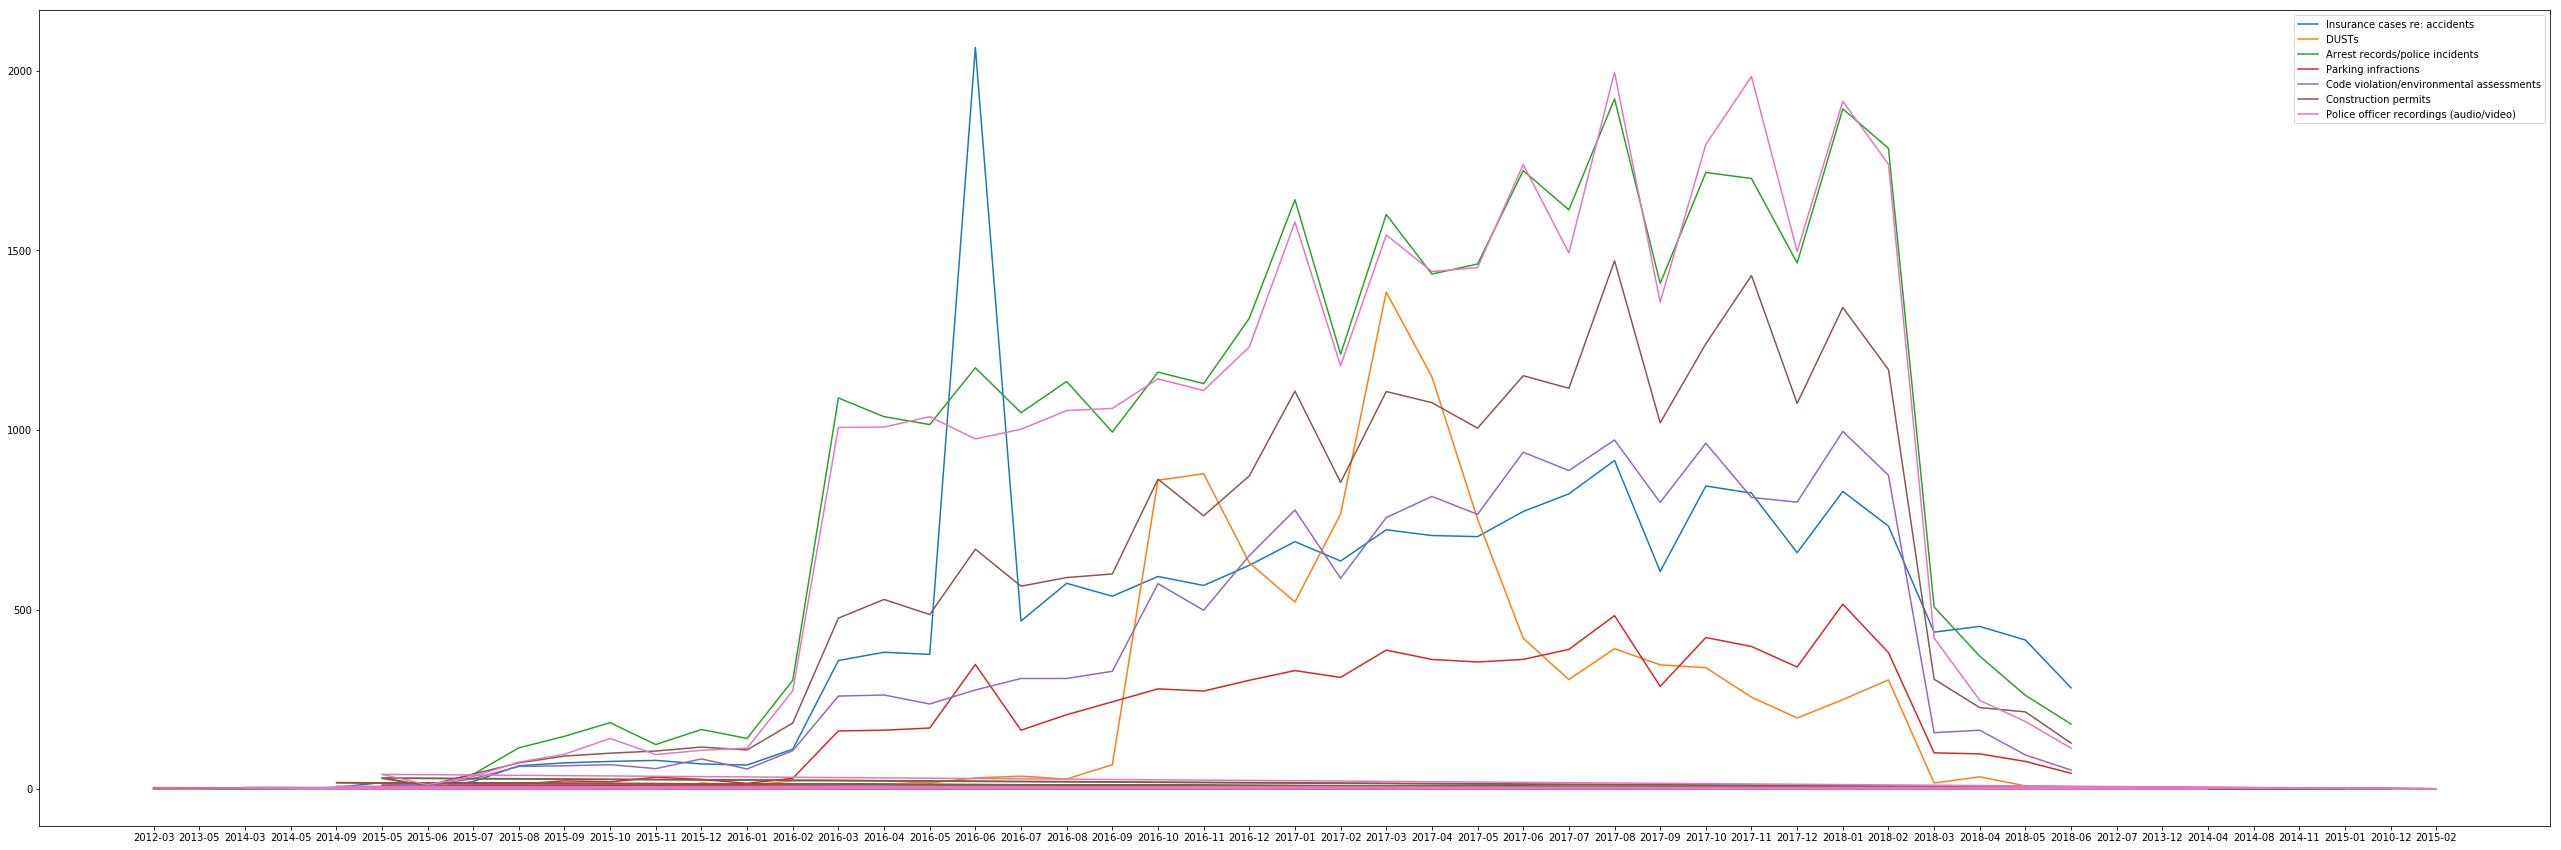

In [537]:
# first let's run the function to get the topics
everything_topic_list = topics_to_list(everything_model)

# then we'll run each topic through the list comprehension and build a dataframe
topic_model_dfs = [count_keywords(words_over_time, 'word', i) for i in everything_topic_list]

# that information above? we'll grab the list indicies of interest
# and the titles of the topics
relevant_full_model = [0, 1, 2, 5, 6, 7, 8]
relevant_titles = ['Insurance cases re: accidents', 'DUSTs',
                   'Arrest records/police incidents',
                   'Parking infractions',
                   'Code violation/environmental assessments',
                   'Construction permits',
                   'Police officer recordings (audio/video)']

# this list comprehension filters out the indices we don't care about
plot_full = [topic_model_dfs[i] for i in relevant_full_model]

# and this section is for plotting; set the figure size
plt.figure(figsize=(45,15))
[ plt.plot(datum) for datum in plot_full]
plt.legend(relevant_titles)
#plt.title('Decommissioned Underground Storage Tank Topic Popularity Over Time')

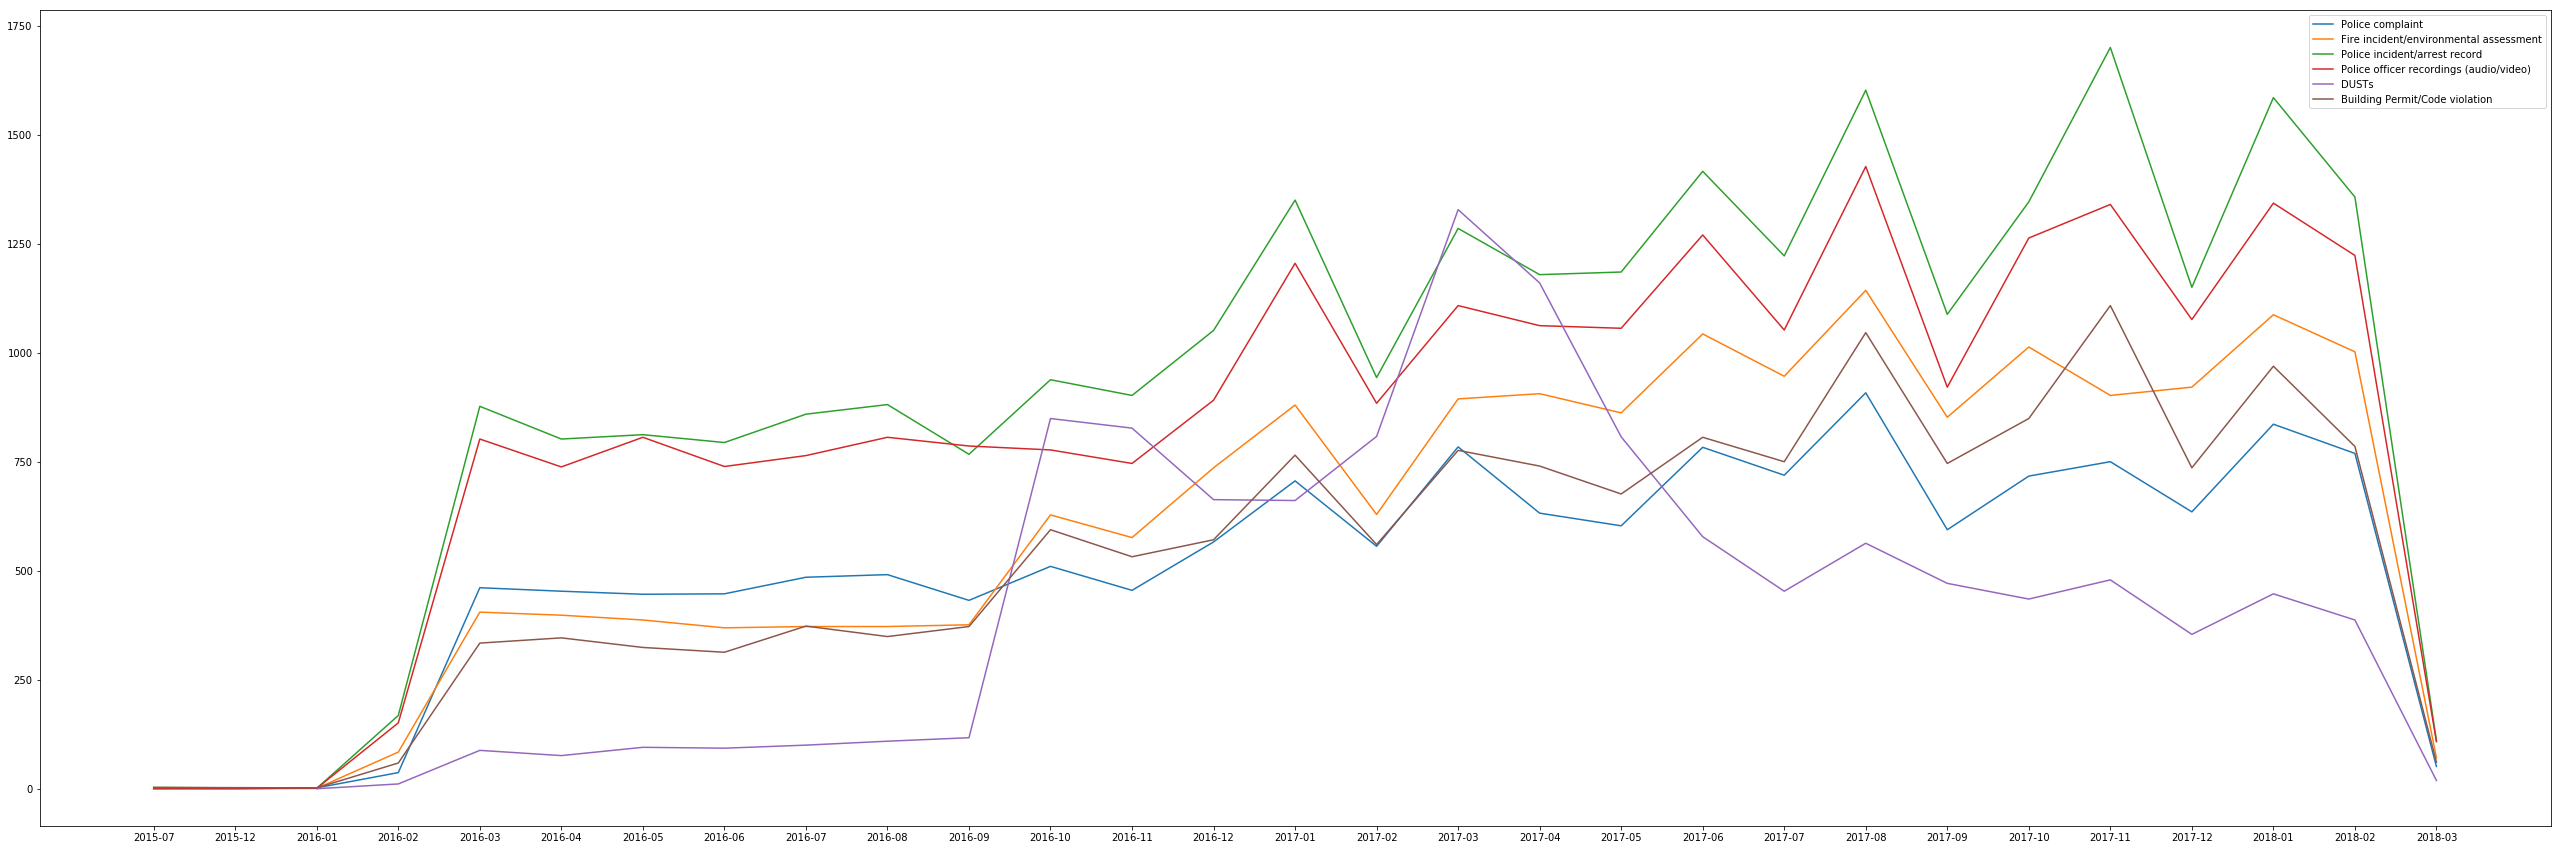

In [513]:
# first let's run the function to get the topics
seattle_topic_list = topics_to_list(sea_model)

# then we'll run each topic through the list comprehension and build a dataframe
seattle_model_dfs = [count_keywords(sea_words_over_time, 'word', i) for i in seattle_topic_list]

# that information above? we'll grab the list indicies of interest
# and the titles of the topics
relevant_sea_model = [0, 2, 4, 5, 7, 9]
relevant_sea_titles = ['Police complaint',
                   'Fire incident/environmental assessment',
                   'Police incident/arrest record',
                   'Police officer recordings (audio/video)',
                   'DUSTs',
                   'Building Permit/Code violation']

# this list comprehension filters out the indices we don't care about
plot_sea = [seattle_model_dfs[i] for i in relevant_sea_model]

# and this section is for plotting; set the figure size
plt.figure(figsize=(45,15))
[ plt.plot(datum) for datum in plot_sea]
plt.legend(relevant_sea_titles)
#plt.title('Decommissioned Underground Storage Tank Topic Popularity Over Time')

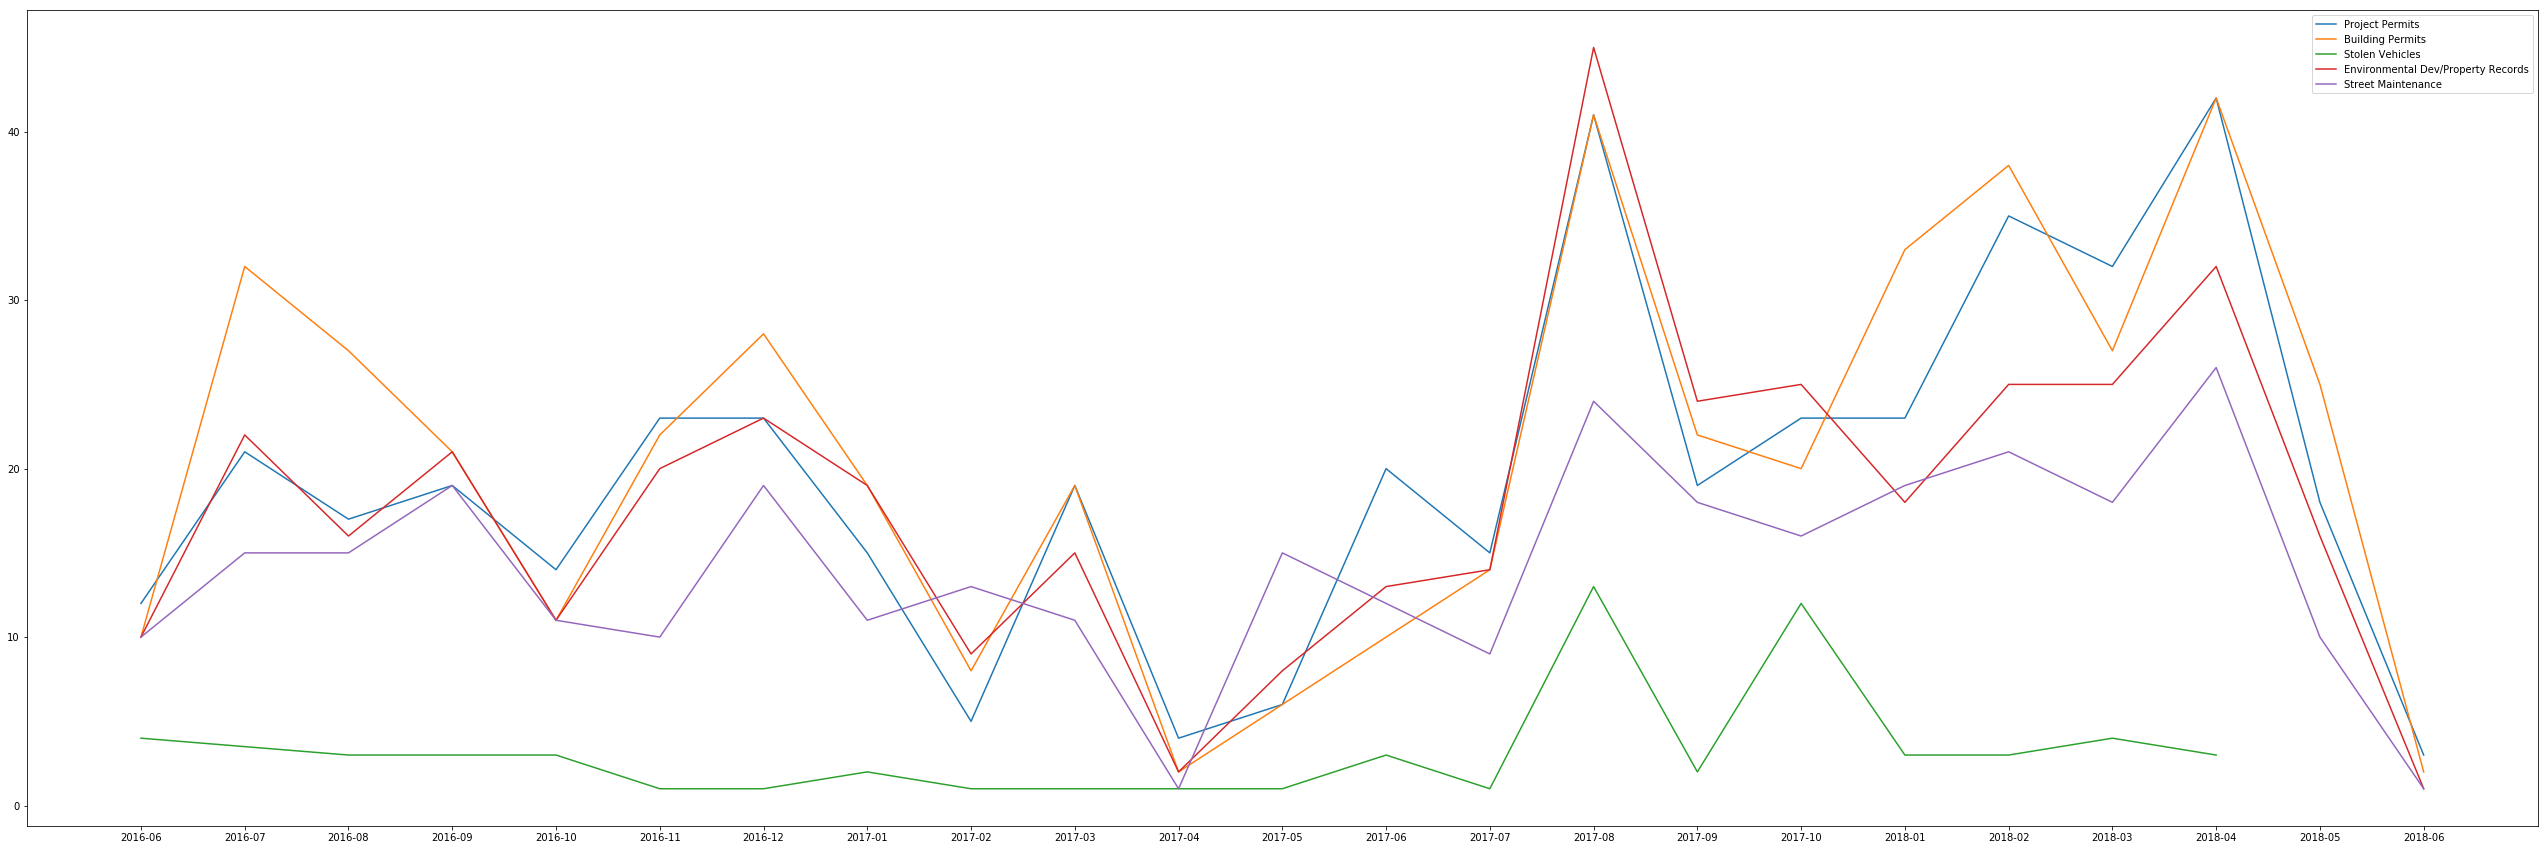

In [514]:
# first let's run the function to get the topics
orchard_topic_list = topics_to_list(por_model)

# then we'll run each topic through the list comprehension and build a dataframe
orchard_model_dfs = [count_keywords(por_words_over_time, 'word', i) for i in orchard_topic_list]

# that information above? we'll grab the list indicies of interest
# and the titles of the topics
relevant_por_model = [2, 4, 5, 6, 8]
relevant_por_titles = ['Project Permits',
                   'Building Permits',
                   'Stolen Vehicles',
                   'Environmental Dev/Property Records',
                   'Street Maintenance']

# this list comprehension filters out the indices we don't care about
plot_por = [orchard_model_dfs[i] for i in relevant_por_model]

# and this section is for plotting; set the figure size
plt.figure(figsize=(45,15))
[ plt.plot(datum) for datum in plot_por]
plt.legend(relevant_por_titles)
#plt.title('Decommissioned Underground Storage Tank Topic Popularity Over Time')

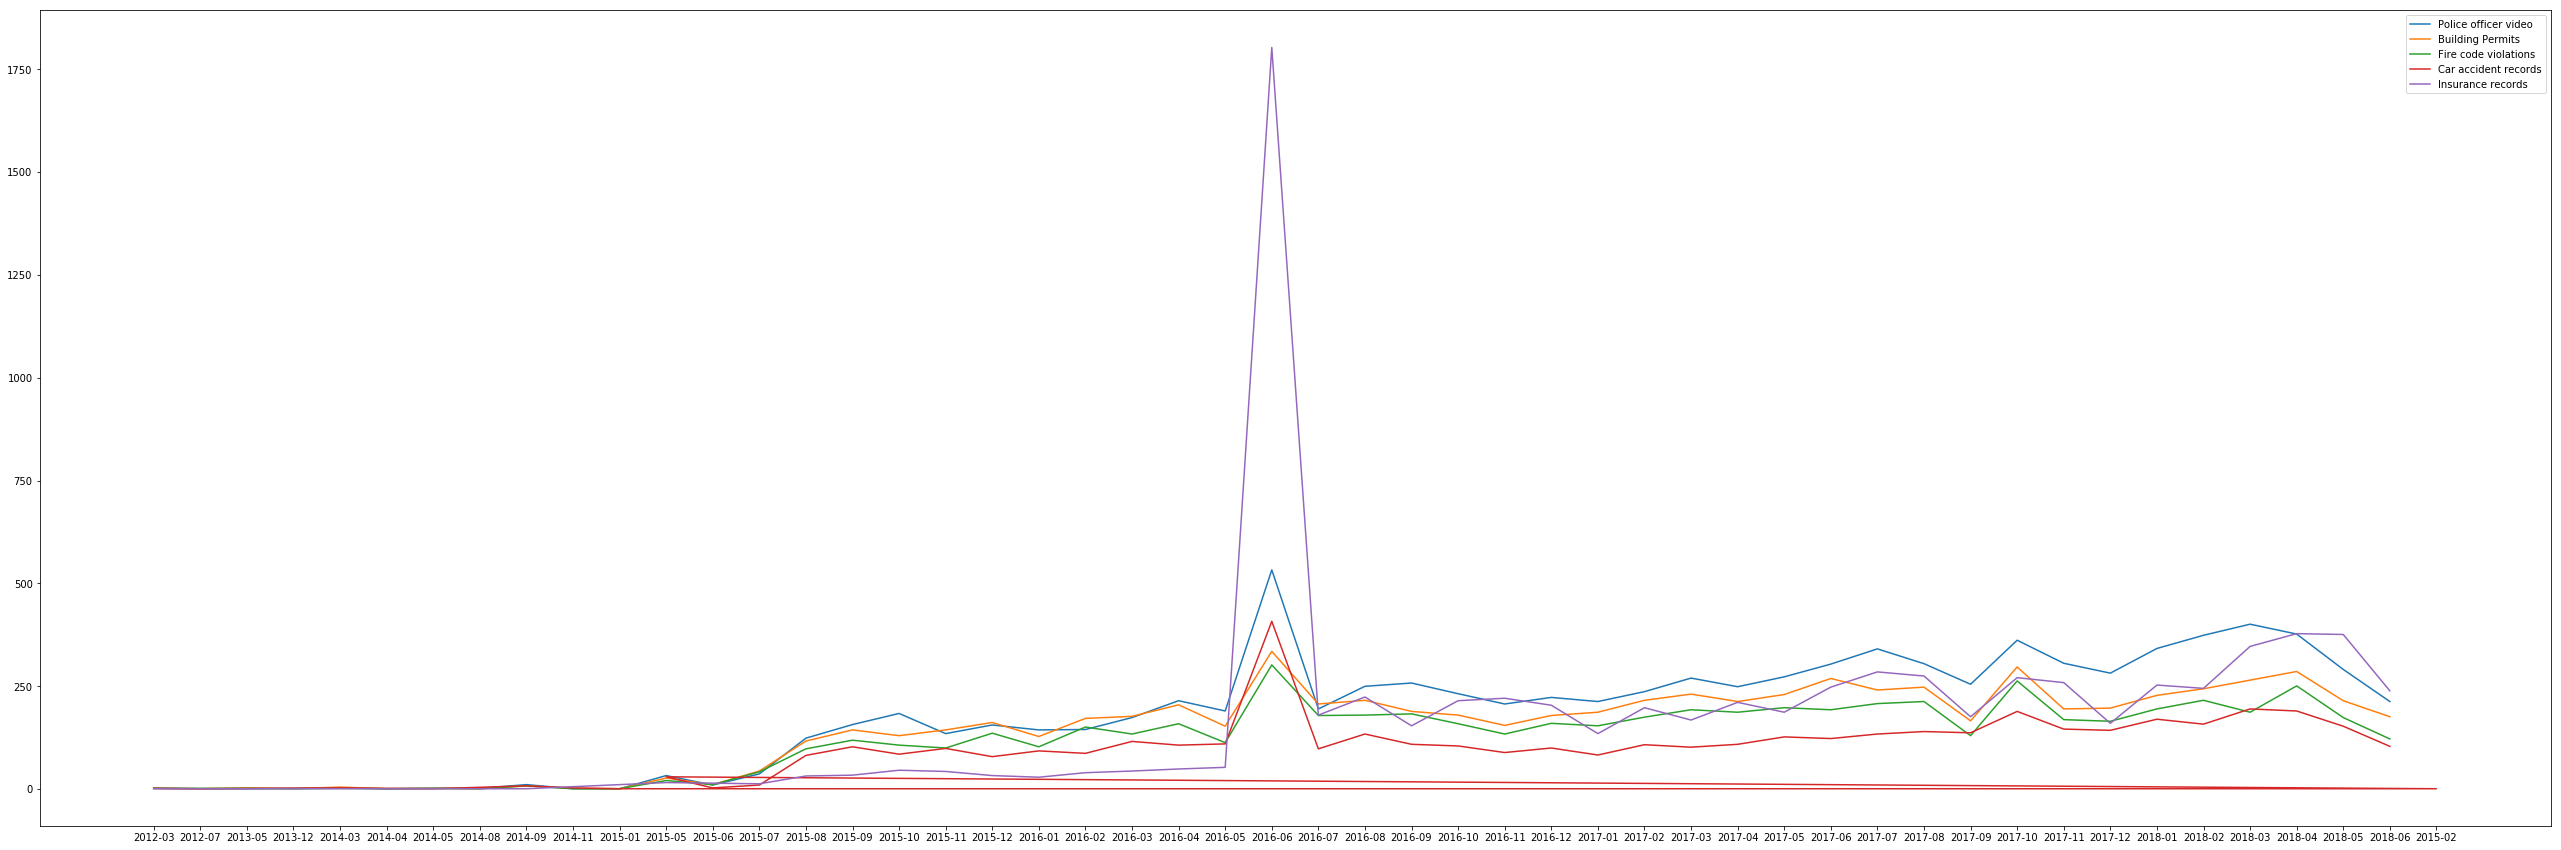

In [525]:
# first let's run the function to get the topics
olympia_topic_list = topics_to_list(oly_model)

# then we'll run each topic through the list comprehension and build a dataframe
olympia_model_dfs = [count_keywords(oly_words_over_time, 'word', i) for i in olympia_topic_list]

# that information above? we'll grab the list indicies of interest
# and the titles of the topics
relevant_oly_model = [0, 1, 2, 3, 7]
relevant_oly_titles = ['Police officer video',
                   'Building Permits',
                   'Fire code violations',
                   'Car accident records',
                   'Insurance records']

# this list comprehension filters out the indices we don't care about
plot_oly = [olympia_model_dfs[i] for i in relevant_oly_model]

# and this section is for plotting; set the figure size
plt.figure(figsize=(45,15))
[ plt.plot(datum) for datum in plot_oly]
plt.legend(relevant_oly_titles)
#plt.title('Decommissioned Underground Storage Tank Topic Popularity Over Time')

# Correlation Matricies
We've successfully plotted the topics we found, but now we have to establish how discrete the topics are. We can attempt this by looking at correlations between the way they move over time.

In [516]:
# correlation matrix for each topic within the oly dataframe
# group the list of dataframes into one big one
oly_condensed = pd.concat([i for i in plot_oly], axis=1, sort=False)
# fill NA values with 0s
oly_condensed = oly_condensed.fillna(0)
# change the columns for readability
oly_condensed.columns = ["OLY: "+ str(i) for i in relevant_oly_titles]
# generate the correlation matrix
oly_condensed.corr()

,OLY: Police officer video,OLY: Building Permits,OLY: Fire code violations,OLY: Car accident records,OLY: Insurance records
OLY: Police officer video,1.000000,0.968288,0.967148,0.944561,0.706119
OLY: Building Permits,0.968288,1.000000,0.991269,0.899493,0.609241
OLY: Fire code violations,0.967148,0.991269,1.000000,0.902637,0.634784
OLY: Car accident records,0.944561,0.899493,0.902637,1.000000,0.844240
OLY: Insurance records,0.706119,0.609241,0.634784,0.844240,1.000000


In [517]:
# correlation matrix for each topic within the por dataframe
por_condensed = pd.concat([i for i in plot_por], axis=1, sort=False)
por_condensed = por_condensed.fillna(0)
por_condensed.columns = ["POR: "+ str(i) for i in relevant_por_titles]
por_condensed.corr()

,POR: Project Permits,POR: Building Permits,POR: Stolen Vehicles,POR: Environmental Dev/Property Records,POR: Street Maintenance
POR: Project Permits,1.000000,0.904112,0.522576,0.913293,0.810921
POR: Building Permits,0.904112,1.000000,0.363084,0.875392,0.822691
POR: Stolen Vehicles,0.522576,0.363084,1.000000,0.643300,0.479777
POR: Environmental Dev/Property Records,0.913293,0.875392,0.643300,1.000000,0.840439
POR: Street Maintenance,0.810921,0.822691,0.479777,0.840439,1.000000


In [518]:
# correlation matrix for each topic within the sea dataframe
sea_condensed = pd.concat([i for i in plot_sea], axis=1, sort=False)
sea_condensed = sea_condensed.fillna(0)
sea_condensed.columns = ["SEA: "+ str(i) for i in relevant_sea_titles]
sea_condensed.corr()

,SEA: Police complaint,SEA: Fire incident/environmental assessment,SEA: Police incident/arrest record,SEA: Police officer recordings (audio/video),SEA: DUSTs,SEA: Building Permit/Code violation
SEA: Police complaint,1.000000,0.954936,0.986077,0.989220,0.620551,0.949506
SEA: Fire incident/environmental assessment,0.954936,1.000000,0.950891,0.946569,0.679887,0.972388
SEA: Police incident/arrest record,0.986077,0.950891,1.000000,0.992732,0.602781,0.969653
SEA: Police officer recordings (audio/video),0.989220,0.946569,0.992732,1.000000,0.579077,0.949999
SEA: DUSTs,0.620551,0.679887,0.602781,0.579077,1.000000,0.658276
SEA: Building Permit/Code violation,0.949506,0.972388,0.969653,0.949999,0.658276,1.000000


In [519]:
# correlation matrix for each topic within the full dataframe
full_condensed = pd.concat([i for i in plot_full], axis=1, sort=False)
full_condensed = full_condensed.fillna(0)
full_condensed.columns = ["ALL: "+ str(i) for i in relevant_titles]
full_condensed.corr()

,ALL: Insurance cases re: accidents,ALL: DUSTs,ALL: Arrest records/police incidents,ALL: Parking infractions,ALL: Code violation/environmental assessments,ALL: Construction permits,ALL: Police officer recordings (audio/video)
ALL: Insurance cases re: accidents,1.000000,0.478483,0.825371,0.861723,0.743117,0.802978,0.799125
ALL: DUSTs,0.478483,1.000000,0.642770,0.673623,0.693043,0.674599,0.636123
ALL: Arrest records/police incidents,0.825371,0.642770,1.000000,0.980647,0.961363,0.984833,0.995714
ALL: Parking infractions,0.861723,0.673623,0.980647,1.000000,0.966257,0.985561,0.977981
ALL: Code violation/environmental assessments,0.743117,0.693043,0.961363,0.966257,1.000000,0.984427,0.964700
ALL: Construction permits,0.802978,0.674599,0.984833,0.985561,0.984427,1.000000,0.989562
ALL: Police officer recordings (audio/video),0.799125,0.636123,0.995714,0.977981,0.964700,0.989562,1.000000


In [520]:
# and now, the correlation between all of the four different dataframes
huge_corr_matrix = pd.concat([full_condensed,
                              sea_condensed,
                              por_condensed,
                              oly_condensed], axis=1, sort=False)
huge_corr_matrix.corr()

,ALL: Insurance cases re: accidents,ALL: DUSTs,ALL: Arrest records/police incidents,ALL: Parking infractions,ALL: Code violation/environmental assessments,ALL: Construction permits,ALL: Police officer recordings (audio/video),SEA: Police complaint,SEA: Fire incident/environmental assessment,SEA: Police incident/arrest record,...,POR: Project Permits,POR: Building Permits,POR: Stolen Vehicles,POR: Environmental Dev/Property Records,POR: Street Maintenance,OLY: Police officer video,OLY: Building Permits,OLY: Fire code violations,OLY: Car accident records,OLY: Insurance records
ALL: Insurance cases re: accidents,1.000000,0.478483,0.825371,0.861723,0.743117,0.802978,0.799125,0.585578,0.517001,0.573892,...,-0.068768,-0.145968,0.310724,-0.050159,-0.031751,0.874895,0.820241,0.844683,0.874958,0.837780
ALL: DUSTs,0.478483,1.000000,0.642770,0.673623,0.693043,0.674599,0.636123,0.475038,0.536334,0.449116,...,-0.297295,-0.374271,-0.166586,-0.275721,-0.310911,0.377225,0.418136,0.433827,0.210682,0.126909
ALL: Arrest records/police incidents,0.825371,0.642770,1.000000,0.980647,0.961363,0.984833,0.995714,0.989238,0.961156,0.984579,...,0.076518,0.053750,0.378413,0.179906,0.175453,0.768260,0.774439,0.784564,0.624828,0.383476
ALL: Parking infractions,0.861723,0.673623,0.980647,1.000000,0.966257,0.985561,0.977981,0.941054,0.942551,0.935595,...,0.042072,-0.001189,0.423637,0.130864,0.142868,0.780235,0.763364,0.783883,0.647448,0.453158
ALL: Code violation/environmental assessments,0.743117,0.693043,0.961363,0.966257,1.000000,0.984427,0.964700,0.911581,0.988271,0.911259,...,0.064460,-0.005630,0.351762,0.151540,0.131700,0.695401,0.694157,0.706407,0.519189,0.279227
ALL: Construction permits,0.802978,0.674599,0.984833,0.985561,0.984427,1.000000,0.989562,0.953115,0.977826,0.965078,...,0.076826,0.027323,0.417784,0.191463,0.149516,0.742636,0.737378,0.751348,0.586331,0.354501
ALL: Police officer recordings (audio/video),0.799125,0.636123,0.995714,0.977981,0.964700,0.989562,1.000000,0.982288,0.961261,0.992616,...,0.082882,0.055597,0.413006,0.196474,0.185315,0.736113,0.740750,0.752189,0.586461,0.341413
SEA: Police complaint,0.585578,0.475038,0.989238,0.941054,0.911581,0.953115,0.982288,1.000000,0.954936,0.986077,...,0.114543,0.133114,0.271293,0.153985,0.077308,0.488333,0.516573,0.532074,0.220867,0.124988
SEA: Fire incident/environmental assessment,0.517001,0.536334,0.961156,0.942551,0.988271,0.977826,0.961261,0.954936,1.000000,0.950891,...,0.107491,0.037890,0.274873,0.129044,0.046801,0.465237,0.470198,0.483899,0.163701,0.053775
SEA: Police incident/arrest record,0.573892,0.449116,0.984579,0.935595,0.911259,0.965078,0.992616,0.986077,0.950891,1.000000,...,0.096827,0.120944,0.276908,0.143107,0.075935,0.475010,0.485883,0.505433,0.217826,0.113581


# Topics over time: Discussion

There's a lot of noise in the graphs and tables here, but we can see a few things:

- **topic collision is a problem.** If the topics were sufficiently isolated based on their keywords, we should have seen lower correlation coefficients across the board. That said, correlations in the .5-.6 range are okay, and negative correlations are even better, as it shows real independance between the variables. We have those things.
- **we can see history unfolding**. There were some peak moments re: police-related and fire-related topics which decreased substantially over time; these could be based on historical events (i.e. people like T.C. or media publicity regarding underground storage tanks).

In [522]:
# exporting this for use in an alternate notebook
huge_corr_matrix = huge_corr_matrix.fillna(0)
export(huge_corr_matrix, 'topics-over-time')

# Project 4: Cosine similarity using word2Vec

### What is word2Vec?

Word2vec is an algorithmic system used to produce word embeddings. But what is a word embedding? It's the relationship between a word and another word in a document.

Think back to the LDA section of this document. The computer produced a clustering of words, and we used our associative human creativity to establish patterns and relationships between them. What if it were possible to determine the similarity or semantic relationship between words programmatically, based on their context?

Word2vec achieves this by taking a large body of text and representing it as a vector space. Each word contained within that vector space is encoded as a vector, comprised of a 1 where the word is and 0's everywhere else). There is a hidden filter layer which compresses the size of this vector while minimizing information loss, as smaller vectors are less computationally complex to compare. Finally, the word vectors are all positioned in the vector space relative to each other, with more similar words clustered together.

This is quite abstract, so let's try out an example. Assume that we have the sentences "Bananas and apples are delicious," and "Durian and jackfruit are unpleasant." We can represent each of these as a list of words:

`document1 = ['Bananas', 'and', 'apples', 'are', 'delicious', '.']`

`document2 = ['Durian', 'and', 'jackfruit', 'are', 'unpleasant', '.']`

And then as a vector space, like so:

In [23]:
d = {'bananas': [1, 0], 'durian': [0, 1], 'and': [1, 1],
     'apples': [1, 0], 'jackfruit': [0, 1], 'are': [1, 1],
    'delicious': [1, 0], 'unpleasant': [0, 1], '.': [1, 1]}

s  = pd.Series(d,index=d.keys())
s

bananas       [1, 0]
durian        [0, 1]
and           [1, 1]
apples        [1, 0]
jackfruit     [0, 1]
are           [1, 1]
delicious     [1, 0]
unpleasant    [0, 1]
.             [1, 1]
dtype: object

While we have produced an excellent vector space here, we can make the vector space more sparse and easier to work with by dropping items that do not have semantic relevance. That includes words like 'and' and punctuation.

In [24]:
e = {'bananas': [1, 0], 'durian': [0, 1],
     'apples': [1, 0], 'jackfruit': [0, 1],
    'delicious': [1, 0], 'unpleasant': [0, 1]}

t  = pd.Series(e,index=e.keys())
t

bananas       [1, 0]
durian        [0, 1]
apples        [1, 0]
jackfruit     [0, 1]
delicious     [1, 0]
unpleasant    [0, 1]
dtype: object

Again, this is our vector *space*. A *word vector* is the representation of the word with regard to the entire vecor space. The following word vectors are represented like this, relative to their presence within the vector space, and the documents in which they appear:

`bananas = [1, 0, 0, 0, 0, 0]`

`durian = [0, 1, 0, 0, 0, 0]`

`delicious = [0, 0, 0, 0, 1, 0]`

`unpleasant = [0, 0, 0, 0, 0, 1]`

This is a simplistic picture of how a word vector operates. There is little insight that we can derive from this, other than comparing direct equivalence of vectors. But things become interesting when there is a significantly large corpus of documents, with different uses and contexts for words.

Word2vec takes word vectors for every word that appears in a corpus (as above) and represents their contexts as a series of weights. Think of it like creating a dictionary, where each definition is composed of a little piece of every other definition, but to varying degrees. Because each definition of a word is created relationally, it is possible to capture conceptual or syntactic meaning an a really robust, fascinating (almost surprising) way.

Supposing we had more data (a huge set of other documents), the previous word vectors might be transformed to contain all of the "definitions" of the other words within the dataset:

`bananas = [0.89123, 0.66545, 0.19842, 0.11901, 0.09113, 0.07221]`

`durian = [0.12311, 0.71834, 0.22142, 0.13452, 0.08721, 0.067881]`

`delicious = [0.13317, 0.17004, 0.21891, 0.66311, 0.88313, 0.70019]`

`unpleasant = [0.14141, 0.16167, 0.22212, 0.57719, 0.77311, 0.87123]`

Other algorithms can be used to reduce the dimensionality of the vector space, such that each of these vectors can be plotted in 2D space. For a naive explanation of how this works, check out the bolded components of each of these vectors:

`bananas = [`**0.89123`, `0.66545**`, 0.19842, 0.11901, 0.09113, 0.07221]`

`durian = [`**0.71311`, `0.86834**`, 0.22142, 0.13452, 0.08721, 0.067881]`

`delicious = [0.13317, 0.17004, 0.21891, 0.38311, `**0.88313`, `0.70019**`]`

`unpleasant = [0.14141, 0.16167, 0.22212, 0.57719, `**0.77311`, `0.87123**`]`

Representing the vectors in this way, and only looking at a couple of components, it appears that *bananas* and *durian* are more similar, and *delicious* and *unpleasant* are more similar.

By performing vector addition and subtraction, we can see which words have relationships with other words, and better understand the relationships between them.

In [98]:
# in order to do this w2v work, we have to pull all of our data out of the dataframe
# similar to how we did with LDA

def flatten(ls):
    # ARGUMENTS: ls; a list
    # OUTPUTS: a list
    #
    # takes in a list and for each element
    # within an element of the list,
    # adds that element to one level higher
    return [i for s in ls for i in s]

def strip_filter(s):
    # ARGUMENTS: s; a string
    # OUTPUTS: a string
    #
    # forbidden characters
    disallowed = "!#$%^&*()<>?,[]-{}~`;|+=_ :.@/\'"
    
    # string comprehension to combine strings, provided that
    # one of the forbidden characters is not in the set
    filterone = ''.join(c for c in s if c not in disallowed)
    
    # similar to above but removing numbers; just another layer
    return ''.join(f for f in filterone if f.isdigit() == False)

def unpack_flatten(textlist):
    # ARGUMENTS: textlist; a list of spacy tokens
    # OUTPUTS: a list
    #
    # initialize empty list
    texts = []
    # for each list in the list of lists
    for sentence in textlist:
        # produce a list that consists of split, lowercase tokens
        data = [sent.string.strip().lower().split() for sent in sentence.sents]
        # remove one layer of lists
        data = flatten(data)
        # then filter data based on character length to make sure that
        # tokens of no consequence, or weird spaces, don't end up here
        spaces = [clean(datum) for datum in data if len(datum) > 1]
        # filter out punctuation further
        nopunct = [strip_filter(datum) for datum in data]
        # finally append to the list
        texts.append(nopunct)
    return texts

unpacked_sents = unpack(cities, 'tokens')
sentence_list = unpack_flatten(unpacked_sents)

In [99]:
# word2vec
#
# error messages of note, in case further problems arise:
# https://stackoverflow.com/questions/33989826/python-gensim-runtimeerror-you-must-first-build-vocabulary-before-training-th/33991111
# 

# the number of dimensions of generated vectors. this is a good number to
# play around with. some people suggest square-root length of vocabulary
# conceptually this might map onto principle components, or number of topics
size = 50

# terms that occur less than min_count number 
# of times are ignored in calculations
# may want to change this depending on reimplementation of
# lem_stop function above
min_count = 3

# terms that occur within this window of text are associated with it
# during the training of the model. if the corpus of text contains large
# sentences then it may be a good idea to change this to something larger.
# the documentation suggests 10 as an upper bound and 4-7 as a good range.
window = 4

# skip-gram technique: boolean that determines skipgram vs continuous bag of words
# model. the default is 1, skipgram
sg = 1

# as above, this is a random seed for making the results more reproducible
seed = 1

epochs=20

downsampling = 1e-3

prr2vec = Word2Vec(
    sentence_list,
    sg=sg,
    seed=seed,
    size=size,
    min_count=min_count,
    window=window,
    sample=downsampling,
    iter=epochs
)


# and if we're trying to do entities we can just use the same entity variable
# from above
ent2vec = Word2Vec(
    allents,
    sg=sg,
    seed=seed,
    size=size,
    min_count=min_count,
    window=window,
    sample=downsampling,
    iter=epochs
)

'prr2vec = Word2Vec(\n    alldict,\n    sg=sg,\n    size=size,\n    min_count=min_count,\n    window=window\n)'

In [100]:
# after generating the model, we can train the model in order to
# actually generate the word vector relationships
prr2vec.train(sentence_list,
              total_examples=prr2vec.corpus_count,
              epochs=prr2vec.epochs)

# and the same for entitites
ent2vec.train(sentence_list,
              total_examples=prr2vec.corpus_count,
              epochs=prr2vec.epochs)

# this is a helper function to save the output
def save_w2v_model(model, name):
    # ARGUMENTS: model; a word2vec model
    # name; a filename
    #
    # forces the filename to str type
    name = str(name)
    # if this folder doesn't exist, create it
    if not os.path.exists("trained"):
        os.makedirs("trained")
    # then save the file
    model.save(os.path.join("trained", name+".w2v"))

    
# and here's where we actually save
save_w2v_model(prr2vec, "prr2vec-np-filtered")
save_w2v_model(ent2vec, "ent2vec-no-filter")

In [102]:
# this is for loading the pre-saved word vectors
# so we don't repeatedly have to generate them
prr2vec = Word2Vec.load(os.path.join("trained", "prr2vec-np-filtered.w2v"))
ent2vec = Word2Vec.load(os.path.join("trained", "ent2vec-no-filter.w2v"))

# these few lines of code reduce the dimensionality of the word vectors we generated
# to two dimensions, which means that we can visualize them
#
# watch out before running this, because it takes about 10min
tsne = TSNE(n_components=2, random_state=0)

# this is for word vectors
prr_word_vectors_matrix = prr2vec.wv.vectors
prr_word_vectors_matrix_2d = tsne.fit_transform(prr_word_vectors_matrix)

# and this is for entities
ent_vectors_matrix = ent2vec.wv.vectors
ent_vectors_matrix_2d = tsne.fit_transform(ent_vectors_matrix)

In [112]:
# reshape the word vetors into a 2d dataframe, for export
wordpoints = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, prr_word_vectors_matrix_2d[prr2vec.wv.vocab[word].index])
            for word in prr2vec.wv.vocab
        ]
    ],
    columns=["word", "x", "y"]
)

# reshape the entities into a 2d dataframe, for export
entpoints = pd.DataFrame(
    [
        (ent, coords[0], coords[1])
        for ent, coords in [
            (ent, ent_vectors_matrix_2d[ent2vec.wv.vocab[ent].index])
            for ent in ent2vec.wv.vocab
        ]
    ],
    columns=["entity", "x", "y"]
)

In [114]:
# export entities and word vectors as json
export(entpoints, 'entcoords', j=True)
export(wordpoints, 'wordcoords', j=True)

In [180]:
def word_analogy(word0='A', word2='Y', word3='Z'):
    # ARGUMENTS: word0, word2, word3; words in the corpus
    # if the defaults are kept, then B is a default too
    if word0 == 'A' or word2=='Y' or word3=='Z':
        calc = 'B'
    #
    # otherwise compute cosine similarity
    # it helps to think of it like this
    # "King" - "Man" + "Queen" == "Woman"
    #print(w2v_model.wv.most_similar(positive=['woman', 'king'], negative=['man']))
    else:
        calc = prr2vec.wv.most_similar(positive=[word0, word2],
                negative=[word3], topn=1)
    # and return some pretty printing
    return "{0} is to {1} as {2} is to {3}.".format(word0, calc[0][0], word2, word3)

def ent_analogy(word0='A', word2='Y', word3='Z'):
    # ARGUMENTS: word0, word2, word3; words in the corpus
    # if the defaults are kept, then B is a default too
    if word0 == 'A' or word2=='Y' or word3=='Z':
        calc = 'B'
    #
    # otherwise compute cosine similarity
    # it helps to think of it like this
    # "King" - "Man" + "Queen" == "Woman"
    #print(w2v_model.wv.most_similar(positive=['woman', 'king'], negative=['man']))
    else:
        calc = ent2vec.wv.most_similar(positive=[word0, word2],
                negative=[word3], topn=1)
    # and return some pretty printing
    return "{0} is to {1} as {2} is to {3}.".format(word0, calc[0][0], word2, word3)

# amazing word embeddings

#word_analogy('surveillance', 'audio', 'video')
#word_analogy('dashcam', 'underground', 'tanks')
#word_analogy('tank', 'request', 'record')
#word_analogy('permit', 'parcel', 'zoning')
#word_analogy('port', 'olympia', 'seattle')
#word_analogy('state', 'county', 'thurston')

ent_analogy('WA', 'Olympia', 'Washington')
ent_analogy('SPD', 'Kitsap County', 'Port Orchard')

'SPD is to Israel as Kitsap County is to Port Orchard.'

In [157]:
ent2vec.wv.most_similar('Seattle')

[('98108', 0.6062653064727783),
 ('the past 5 years', 0.5854272246360779),
 ('98106', 0.5623888969421387),
 ('Martin Luther King', 0.5606708526611328),
 ('S.', 0.5523542165756226),
 ('98144', 0.5521389245986938),
 ('98125', 0.5518790483474731),
 ('Vios Cafe', 0.548927366733551),
 ('98133', 0.5426791906356812),
 ('98118', 0.5414639115333557)]

# Opportunities for Further Analysis

- **Computing bi-grams and tri-grams** may give us further insight beyond the relationships between named entities, allowing us to see phrases of note that frequently reoccur. I attempted this briefly, but could not find parameters to make the analysis viable. For example, this StackOverflow post may provide more context/insight: https://stackoverflow.com/questions/21844546/forming-bigrams-of-words-in-list-of-sentences-with-python

